# COMP90049 Assignment 2

### Libaries

In [21]:
# Libraries imported and used for assignment

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config 
set_config(print_changed_only=False)
warnings.filterwarnings(action='ignore')

### Helper functions

In [22]:
# Helper functions used for the assignments

# reads the csv files and imports the data ina  dataframe
# removes track id from labels before processing
def read_files():
    train_features = pd.read_csv("train_features.csv")
    train_labels = pd.read_csv("train_labels.csv")
    valid_features = pd.read_csv("valid_features.csv")
    valid_labels = pd.read_csv("valid_labels.csv")
    test_features = pd.read_csv("test_features.csv")
    
    converted_train_labels, converted_valid_labels, label_encoder = convert_labels_numeric(train_labels, valid_labels)
    
    return train_features, converted_train_labels, valid_features, converted_valid_labels, test_features, label_encoder

# splits features for a given column range
def split_features(features, column1, column2):
    new_feature_set = features.loc[:,column1:column2]
    return new_feature_set

# converts a textual feature column into tfidf vector
def text_features_tfidf(train_features,valid_features,test_features,text_column):
    train_column = train_features.loc[:,text_column]
    valid_column = valid_features.loc[:,text_column]
    test_column = test_features.loc[:,text_column]
    
    train_library = train_column.tolist()
    valid_library = valid_column.tolist()
    test_library = test_column.tolist()
    
    text_vector = TfidfVectorizer()
    text_vector.fit(train_library)
    
    train_values = text_vector.transform(train_library)
    valid_values = text_vector.transform(valid_library)
    test_values = text_vector.transform(test_library)
    
    tfidf_train_features = train_values.toarray()
    tfidf_valid_features = valid_values.toarray()
    tfidf_test_features = test_values.toarray()
    
    return tfidf_train_features, tfidf_valid_features, tfidf_test_features

# converts string labels into numveric values
def convert_labels_numeric(train_labels,valid_labels):
    label = LabelEncoder()
    train_genre = train_labels['genre'].tolist()
    valid_genre = valid_labels['genre'].tolist()
    label.fit(train_genre)
    converted_train_labels = label.transform(train_genre)
    converted_valid_labels = label.transform(valid_genre)
    
    return converted_train_labels, converted_valid_labels, label

# scales values between 0 and 1
def min_max_scaler(train_features,valid_features,test_features):
    min_max = MinMaxScaler()
    min_max.fit(train_features)
    scaled_train_values = min_max.transform(train_features)
    scaled_valid_values = min_max.transform(valid_features)
    scaled_test_values = min_max.transform(test_features)
    
    return scaled_train_values, scaled_valid_values, scaled_test_values

# trains a classifier for a given train feature set and train labels
def train(train_features,train_labels,classifier):
    
    trained_classifier = classifier.fit(train_features,train_labels)
    
    return trained_classifier

# predicts values for a classifier for a given feature set
def predict(valid_features,trained_classifier):
    
    predicted_values = trained_classifier.predict(valid_features)
        
    return predicted_values

# evaluates accuracy score for a set of predicted labels
def evaluate(actual_values,predicted_values):
    
    accuracy = accuracy_score(actual_values,predicted_values)

    return accuracy

# plots a bar graph showing the count for each type of genre 
def plot_frequecy_labels(train_labels,label_encoder):
    genre=['Classic Pop and Rock','Dance and Electronica','Folk','Jazz and Blues','Metal','Pop','Punk','Soul and Reggae']
    original_values = label_encoder.inverse_transform(train_labels)
    original_bar,original_count = np.unique(original_values,return_counts=True)
    
    plt.bar(original_bar,original_count)
    plt.xticks(original_bar,genre,rotation=90)
    plt.xlabel("Genres")
    plt.ylabel("Number of values")
    plt.title("Bar graph of Number of values for each Genre in training dataset")
    plt.show()

# plots a multi bar graph showing the counts for each type of genre for different classifiers
def plot_predicted_actual_labels(predicted_DT_labels,predicted_MLP_labels,predicted_DC_labels,valid_labels):
    weight = 0.2
    labels = ['Decision Tree','Multilayer Perceptron','Zero_R','valid']
    genre = ['Classic Pop and Rock','Dance and Electronica','Folk','Jazz and Blues','Metal','Pop','Punk','Soul and Reggae']
    DT_bar,DT_count = np.unique(predicted_DT_labels,return_counts=True)
    MLP_values,MLP_count = np.unique(predicted_MLP_labels,return_counts=True)
    DC_values,DC_count = np.unique(predicted_DC_labels,return_counts=True)
    valid_values,valid_count = np.unique(valid_labels,return_counts=True)
    
    MLP_bar = [values + weight for values in MLP_values]
    DC_bar = [values + weight for values in MLP_bar]
    valid_bar = [values + weight for values in DC_bar]
    
    plt.bar(DT_bar, DT_count,weight,label=labels[0])
    plt.bar(MLP_bar, MLP_count,weight,label=labels[1])
    plt.bar(DC_bar,DC_count,weight,label=labels[2])
    plt.bar(valid_bar,valid_count,weight,label=labels[3])

    plt.xticks(DT_bar + 0.3,genre,rotation=90)
    plt.xlabel("Genres")
    plt.ylabel("Number of values")
    plt.title("Bar graph of Number of values for each Genre")
    plt.legend()
    plt.show()
    
# plots a dataframe for the accuracy score for each type of classifier
def plot_predicted_accuracy(predicted_DT_accuracy,predicted_MLP_accuracy,predicted_DC_accuracy):
    y_values = [predicted_DT_accuracy,predicted_MLP_accuracy,predicted_DC_accuracy]
    x_values = ['DecisionTree','MultilayerPerceptron','Zero_R']
    
    values = {
        'classifier': x_values, 
        'accuracy': y_values
    }
    table = pd.DataFrame(values)
    return table

# initialises the decision tree classifier with hyperparameters for tuning
def decision_tree_classifier():
    
    DT_parameters = {
        'criterion':['gini','entropy']
    }
    
    DT = DecisionTreeClassifier()
    
    return DT, DT_parameters

# initialises the multilayer perceptron with hyperparameters for tuning
def multi_layer_perceptron_classifier():
    
    MLP_parameters = {
        'activation':['logistic','tanh'],
        'solver':['sgd','lbfgs','adam'],
        'max_iter':[2000]
    }
    
    MLP = MLPClassifier()
    
    return MLP, MLP_parameters

# initialises the dummy classifier
def dummy_classifier():
    
    DC_parameters = {}
    
    DC = DummyClassifier()
    
    return DC

# selects features recursively using the RFECV function based on a tuned classifier
def select_features(classifier,train_features,valid_features,test_features,train_labels):
    
    selection = RFECV(classifier,step=1,cv=5, scoring='accuracy')
    
    selection.fit(train_features,train_labels)
    
    print('Number of features selected: {}'.format(selection.n_features_))
    
    x_values = range(1,len(selection.grid_scores_) + 1)
    plt.figure()
    plt.plot(x_values,selection.grid_scores_)
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy score")
    plt.title("Graph of acccuracy score vs Number of features")
    plt.show()
    
    best_train_features = selection.transform(train_features)
    best_valid_features = selection.transform(valid_features)
    best_test_features = selection.transform(test_features)
    
    return best_train_features, best_valid_features, best_test_features

# tunes a classifier based on a given set of hyper parameters
def train_GSCV_classifier(train_features,train_labels,classifier,parameter):
    
    gscv = GridSearchCV(classifier,parameter,scoring='accuracy',cv=5,n_jobs=2,verbose=1)
    
    gscv.fit(train_features,train_labels)
    
    best_classifier = gscv.best_estimator_
    
    print('Best classifier selected: \n{}'.format(best_classifier))
    
    return best_classifier

### Block 1
Used for initialising the classifiers, reading files from csv and removing track id from class labels

In [23]:
# initialises the classifiers
DT, DT_parameters = decision_tree_classifier()
MLP, MLP_parameters = multi_layer_perceptron_classifier()
DC = dummy_classifier()

# reads and preprocesses the csv content
train_features, train_labels, valid_features, valid_labels, test_features, label_encoder = read_files()

### Block 2
Used for spliting audio vectors from the training, validation and testing dataset.
Scales the values between 0 and 1.
Selects the best number of features for audio feature set.
Plots a graph and prints the vector dimensions.

Number of features selected: 85


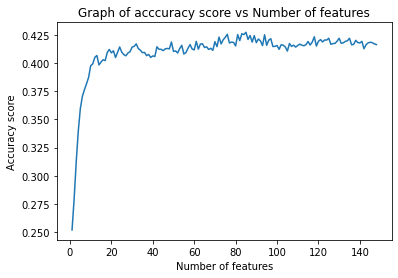

For audio feature set:
Train dataset dimensions: (7678, 85)
Validation dataset dimensions: (450, 85)
Test dataset dimensions: (428, 85)


In [24]:
# audio feature

# splits audio vectors from the dataframes
audio_features = split_features(train_features,'vect_1','vect_148')
valid_audio_features = split_features(valid_features,'vect_1','vect_148')
test_audio_features = split_features(test_features,'vect_1','vect_148')

# scales the audio values
scaled_train_audio, scaled_valid_audio, scaled_test_audio = min_max_scaler(audio_features,valid_audio_features,test_audio_features)

# selects the best number of features from the data and plots a graph
best_train_audio, best_valid_audio, best_test_audio = select_features(DT,scaled_train_audio,scaled_valid_audio,scaled_test_audio,train_labels)

# prints out the vector dimensions
print('For audio feature set:\nTrain dataset dimensions: {}\nValidation dataset dimensions: {}\nTest dataset dimensions: {}'.format(best_train_audio.shape,best_valid_audio.shape,best_test_audio.shape))

### Block 3

User for fine tuning the hyper parameter of the classifiers

In [25]:
# fine tunes the classifiers

best_DT_classifier = train_GSCV_classifier(best_train_audio,train_labels,DT,DT_parameters)

best_MLP_classifier = train_GSCV_classifier(best_train_audio,train_labels,MLP,MLP_parameters)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    5.3s finished


Best classifier selected: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 18.9min finished


Best classifier selected: 
MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


### Block 4 
Used for training the classifier, predicting values and calculating accuracy score for audio data

For audio feature set:
Accuracy of Zero-R: 0.12666666666666668
Accuracy of Decision Tree: 0.30444444444444446
Accuracy of Multilayer Perceptron: 0.45555555555555555


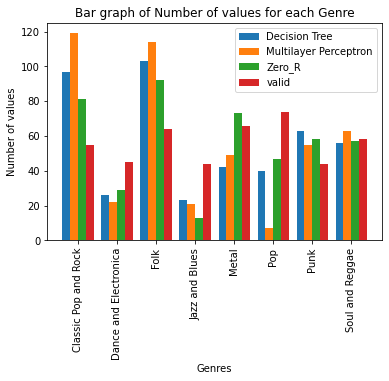

,classifier,accuracy
0,DecisionTree,0.304444
1,MultilayerPerceptron,0.455556
2,Zero_R,0.126667


In [26]:
# trains the classifiers on audio data
# predicts class labels
# calculates the accuracy score for predicted values

# for dummy classifer
audio_DC_classifier = train(best_train_audio,train_labels,DC)
predicted_audio_DC_labels = predict(best_valid_audio,audio_DC_classifier)
audio_DC_accuracy = evaluate(valid_labels,predicted_audio_DC_labels)

# for decision tree
audio_DT_classifier = train(best_train_audio,train_labels,best_DT_classifier)
predicted_audio_DT_labels = predict(best_valid_audio,audio_DT_classifier)
audio_DT_accuracy = evaluate(valid_labels,predicted_audio_DT_labels)

# for multi layer perceptron
audio_MLP_classifier = train(best_train_audio,train_labels,best_MLP_classifier)
predicted_audio_MLP_labels = predict(best_valid_audio,audio_MLP_classifier)
audio_MLP_accuracy = evaluate(valid_labels,predicted_audio_MLP_labels)

# prints out the accuracy
print('For audio feature set:\nAccuracy of Zero-R: {}\nAccuracy of Decision Tree: {}\nAccuracy of Multilayer Perceptron: {}'.format(audio_DC_accuracy,audio_DT_accuracy,audio_MLP_accuracy))

# plots a multi bar graph showing the counts for each type of genre for different classifiers
plot_predicted_actual_labels(predicted_audio_DT_labels,predicted_audio_MLP_labels,predicted_audio_DC_labels,valid_labels)

# plots a dataframe for accuracy score
plot_predicted_accuracy(audio_DT_accuracy,audio_MLP_accuracy,audio_DC_accuracy)

### Block 5
Converts tags to TFIDF vector, scales the values and prints out the dimensions

In [28]:
# lyrical feature

# converts the tags to TFIDF
train_text_features, valid_text_features, test_text_features = text_features_tfidf(train_features,valid_features,test_features,'tags')

# scales the values
scaled_train_text, scaled_valid_text, scaled_test_text = min_max_scaler(train_text_features,valid_text_features,test_text_features)

# prints out the dimensions of the vectors
print('For lyrical(tags) feature set:\nTrain dataset dimensions: {}\nValidation dataset dimensions: {}\nTest dataset dimensions: {}'.format(scaled_train_text.shape,scaled_valid_text.shape,scaled_test_text.shape))

For lyrical(tags) feature set:
Train dataset dimensions: (7678, 4827)
Validation dataset dimensions: (450, 4827)
Test dataset dimensions: (428, 4827)


### Block 6 
Used for training the classifier, predicting values and calculating accuracy score for lyrical data

For lyrical(tags) feature set:
Accuracy of Zero-R: 0.13111111111111112
Accuracy of Decision Tree: 0.3844444444444444
Accuracy of Multilayer Perceptron: 0.5155555555555555


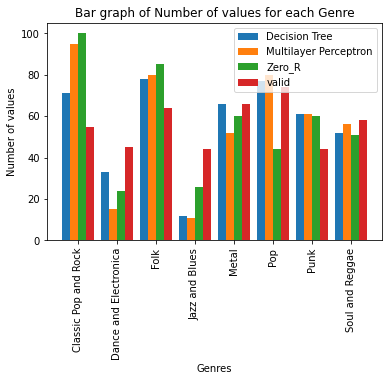

,classifier,accuracy
0,DecisionTree,0.384444
1,MultilayerPerceptron,0.515556
2,Zero_R,0.131111


In [29]:
# trains the classifiers on lyrical data
# predicts class labels
# calculates the accuracy score for predicted values

# for dummy classifer
text_DC_classifier = train(scaled_train_text,train_labels,DC)
predicted_text_DC_labels = predict(scaled_valid_text,text_DC_classifier)
text_DC_accuracy = evaluate(valid_labels,predicted_text_DC_labels)

# for decision tree
text_DT_classifier = train(scaled_train_text,train_labels,best_DT_classifier)
predicted_text_DT_labels = predict(scaled_valid_text,text_DT_classifier)
text_DT_accuracy = evaluate(valid_labels,predicted_text_DT_labels)

# for multi layer perceptron
text_MLP_classifier = train(scaled_train_text,train_labels,best_MLP_classifier)
predicted_text_MLP_labels = predict(scaled_valid_text,text_MLP_classifier)
text_MLP_accuracy = evaluate(valid_labels,predicted_text_MLP_labels)

# prints out the accuracy
print('For lyrical(tags) feature set:\nAccuracy of Zero-R: {}\nAccuracy of Decision Tree: {}\nAccuracy of Multilayer Perceptron: {}'.format(text_DC_accuracy,text_DT_accuracy,text_MLP_accuracy))

# plots a multi bar graph showing the counts for each type of genre for different classifiers
plot_predicted_actual_labels(predicted_text_DT_labels,predicted_text_MLP_labels,predicted_text_DC_labels,valid_labels)

# plots a dataframe for accuracy score
plot_predicted_accuracy(text_DT_accuracy,text_MLP_accuracy,text_DC_accuracy)

### Block 7
Converts title to TFIDF vector, selects the best number of metadata features scales the values and prints out the dimensions

Number of features selected: 4


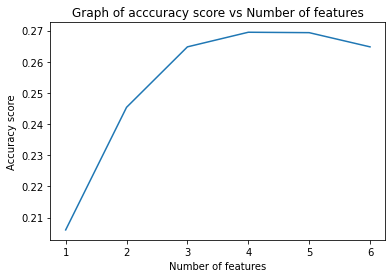

In [30]:
# metadata feature

# converts the title to TFIDF
train_title_features, valid_title_features, test_title_features = text_features_tfidf(train_features,valid_features,test_features,'title')

# splits the metadata from the dataframes
train_audio_property_features = split_features(train_features,'loudness','duration')
valid_audio_property_features = split_features(valid_features,'loudness','duration')
test_audio_property_features = split_features(test_features,'loudness','duration')

# scales the metadata
scaled_train_meta, scaled_valid_meta, scaled_test_meta = min_max_scaler(train_audio_property_features,valid_audio_property_features,test_audio_property_features)

# scales the title
scaled_train_title, scaled_valid_title, scaled_test_title = min_max_scaler(train_title_features,valid_title_features,test_title_features)

# selects the best number of features from the data and plots a graph for metadata
best_train_meta, best_valid_meta, best_test_meta = select_features(DT,scaled_train_meta,scaled_valid_meta,scaled_test_meta,train_labels)

### Block 8
Combine metadata values and print the feature vector dimensions

In [31]:
# concatenate values
train_meta_features = np.concatenate((scaled_train_title,best_train_meta), axis=1)
valid_meta_features = np.concatenate((scaled_valid_title,best_valid_meta), axis=1)
test_meta_features = np.concatenate((scaled_test_title,best_test_meta), axis=1)

# print feature vectors
print('For metadata feature set:\nTrain dataset dimensions: {}\nValidation dataset dimensions: {}\nTest dataset dimensions: {}'.format(train_meta_features.shape,valid_meta_features.shape,test_meta_features.shape))

For metadata feature set:
Train dataset dimensions: (7678, 6353)
Validation dataset dimensions: (450, 6353)
Test dataset dimensions: (428, 6353)


### Block 9
Used for training the classifier, predicting values and calculating accuracy score for metadata

For metadata feature set:
Accuracy of Zero-R: 0.14222222222222222
Accuracy of Decision Tree: 0.23333333333333334
Accuracy of Multilayer Perceptron: 0.3111111111111111


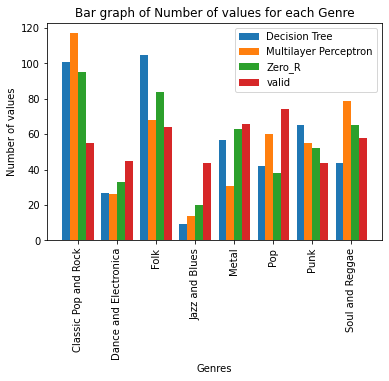

,classifier,accuracy
0,DecisionTree,0.233333
1,MultilayerPerceptron,0.311111
2,Zero_R,0.142222


In [32]:
# trains the classifiers on lyrical data
# predicts class labels
# calculates the accuracy score for predicted values

# for dummy classifer
meta_DC_classifier = train(train_meta_features,train_labels,DC)
predicted_meta_DC_labels = predict(valid_meta_features,meta_DC_classifier)
metadata_DC_accuracy = evaluate(valid_labels,predicted_meta_DC_labels)

# for decision tree
meta_DT_classifier = train(train_meta_features,train_labels,best_DT_classifier)
predicted_meta_DT_labels = predict(valid_meta_features,meta_DT_classifier)
metadata_DT_accuracy = evaluate(valid_labels,predicted_meta_DT_labels)

# for multi layer perceptron
meta_MLP_classifier = train(train_meta_features,train_labels,best_MLP_classifier)
predicted_meta_MLP_labels = predict(valid_meta_features,meta_MLP_classifier)
metadata_MLP_accuracy = evaluate(valid_labels,predicted_meta_MLP_labels)

# prints out the accuracy
print('For metadata feature set:\nAccuracy of Zero-R: {}\nAccuracy of Decision Tree: {}\nAccuracy of Multilayer Perceptron: {}'.format(metadata_DC_accuracy,metadata_DT_accuracy,metadata_MLP_accuracy))

# plots a multi bar graph showing the counts for each type of genre for different classifiers
plot_predicted_actual_labels(predicted_meta_DT_labels,predicted_meta_MLP_labels,predicted_meta_DC_labels,valid_labels)

# plots a dataframe for accuracy score
plot_predicted_accuracy(metadata_DT_accuracy,metadata_MLP_accuracy,metadata_DC_accuracy)

### Block 10
Plots a bar graph showing the count for each type of genre 

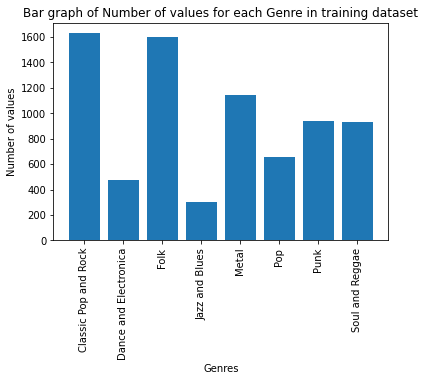

In [33]:
# plots the graph
plot_frequecy_labels(train_labels,label_encoder)

### Block 11
Used for training the classifier, predicting values and calculating accuracy score for best feature set from test data

In [34]:
# test with test_features using best data type and best classifier
# We obtained text features as best type of features and MLP classifier as best classifier
test_classifier = train(scaled_train_text,train_labels,text_MLP_classifier)
predicted_test_labels = predict(scaled_test_text,test_classifier)
converted_predicted_labels = label_encoder.inverse_transform(predicted_test_labels)
test_labels = pd.concat([test_features['trackID'],pd.DataFrame(converted_predicted_labels,columns=['genre'])], axis=1)

# import to csv
test_labels.to_csv('test_labels.csv',index=False)